In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import json
from myGenerator import DataGenerator

### Carga de datos

In [3]:
train = pd.read_pickle("pan22-authorship-verification-training-dataset/particionesXid/PanTrain.plk")
val = pd.read_pickle("pan22-authorship-verification-training-dataset/particionesXid/PanVal.plk")

In [4]:
def spectraLoader(inputPath: str) -> pd.DataFrame:
    df = pd.DataFrame()
    with open(inputPath, encoding='utf-8') as f:
        for line in f:
            jsonline = json.loads(line)
            lineDf = pd.DataFrame({'id':jsonline['id'], 'spectra':[np.array(jsonline['spectra'])]})
            df = pd.concat([df, lineDf])
    df = df.reset_index(drop=True)

    return df

In [5]:
full_spectra = spectraLoader("pan22-authorship-verification-training-dataset/particionesXid/FullSpectra.jsonl")

In [6]:
def loadLabels(inputPath:str, labelDict:dict) -> dict:
    with open(inputPath, encoding='utf-8') as f:
        for line in f:
            jsonline = json.loads(line)
            labelDict[jsonline['id']] = 1 if jsonline['value'] else 0
        
    return labelDict

In [7]:
labels = dict()
labels = loadLabels('pan22-authorship-verification-training-dataset/particiones/train_truth.jsonl',labels)
labels = loadLabels('pan22-authorship-verification-training-dataset/particiones/val_truth.jsonl',labels)

In [8]:
print("Instances: {}".format((train.shape[0] + val.shape[0])/2))
print("Labels: ",len(labels))

Instances: 16486.0
Labels:  16486


In [9]:
partition = {'train': train.id.unique().tolist(), 'validation': val.id.unique().tolist()}

In [10]:
print("Train: ", len(partition['train']))
print("Validation: ", len(partition['validation']))
print("Total: ", len(partition['train'])+len(partition['validation']))

Train:  15732
Validation:  754
Total:  16486


### Definición de la arquitectura del modelo

In [11]:
# Modelo de red siamesa utilizando una red residual y un perceptron multicapa SIN CAPAS CUSTOM

def setModel():
    x1 = tf.keras.Input(shape=(1200,), name="input_1")
    x2 = tf.keras.Input(shape=(1200,), name="input_2")

    # Batch normalization
    bn_layer = tf.keras.layers.BatchNormalization(name="Batch_normalization")
    bn1 = bn_layer(x1)
    bn2 = bn_layer(x2)

    # Gaussian noise
    gaussian_noise_layer = tf.keras.layers.GaussianNoise(1.0, name="Gaussian_noise")
    gn1 = gaussian_noise_layer(bn1)
    gn2 = gaussian_noise_layer(bn2)

    # Dropout
    dropout_layer = tf.keras.layers.Dropout(0.4, name="Dropout_1")
    do1 = dropout_layer(gn1)
    do2 = dropout_layer(gn2)

    # Residual network
    dense_layer_1 = tf.keras.layers.Dense(512, activation='relu', name="resdense_1")
    o1_1 = dense_layer_1(do1)
    o1_2 = dense_layer_1(do2)

    dense_layer_2 = tf.keras.layers.Dense(512, activation='relu', name="resdense_2")
    o2_1 = dense_layer_2(o1_1)
    o2_2 = dense_layer_2(o1_2)

    # Residual layer
    dense_layer_3 = tf.keras.layers.Dense(512, activation='relu', name="resdense_3")
    o3_1 = dense_layer_3(tf.subtract(o1_1, o2_1))
    o3_2 = dense_layer_3(tf.subtract(o1_2, o2_2))

    dense_layer_4 = tf.keras.layers.Dense(512, activation='relu', name="resdense_4")
    o4_1 = dense_layer_4(o3_1)
    o4_2 = dense_layer_4(o3_2)

    # # Residual layer
    # dense_layer_5 = tf.keras.layers.Dense(256, activation='relu', name="resdense_5")
    # o5_1 = dense_layer_5(tf.subtract(o3_1, o4_1))
    # o5_2 = dense_layer_5(tf.subtract(o3_2, o4_2))

    # dense_layer_6 = tf.keras.layers.Dense(256, activation='relu', name="resdense_6")
    # o6_1 = dense_layer_6(o5_1)
    # o6_2 = dense_layer_6(o5_2)

    # # Residual layer
    # dense_layer_7 = tf.keras.layers.Dense(256, activation='relu', name="resdense_7")
    # o7_1 = dense_layer_7(tf.subtract(o5_1, o6_1))
    # o7_2 = dense_layer_7(tf.subtract(o5_2, o6_2))

    # dense_layer_8 = tf.keras.layers.Dense(256, activation='relu', name="resdense_8")
    # o8_1 = dense_layer_8(o7_1)
    # o8_2 = dense_layer_8(o7_2)

    # # Residual layer
    # dense_layer_9 = tf.keras.layers.Dense(256, activation='relu', name="resdense_9")
    # o9_1 = dense_layer_9(tf.subtract(o7_1, o8_1))
    # o9_2 = dense_layer_9(tf.subtract(o7_2, o8_2))

    # Merging
    # merge = tf.math.abs(tf.subtract(o9_1,o9_2))
    merge = tf.subtract(o4_1,o4_2)

    # MLPNN Classifier
    dense1 = tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(merge)
    do3 = tf.keras.layers.Dropout(0.4)(dense1)
    bn1 = tf.keras.layers.BatchNormalization()(do3)
    dense2 = tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(bn1)
    do4 = tf.keras.layers.Dropout(0.4)(dense2)
    bn2 = tf.keras.layers.BatchNormalization()(do4)
    output = tf.keras.layers.Dense(1, activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l2(0.001))(bn2)

    model = tf.keras.Model([x1, x2], output)
    model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics=["binary_accuracy"])

    return model

In [12]:
model = setModel()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1200)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1200)]       0           []                               
                                                                                                  
 Batch_normalization (BatchNorm  (None, 1200)        4800        ['input_1[0][0]',                
 alization)                                                       'input_2[0][0]']                
                                                                                                  
 Gaussian_noise (GaussianNoise)  (None, 1200)        0           ['Batch_normalization[0][0]',

2022-05-23 23:19:34.526046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 23:19:34.567379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 23:19:34.567501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 23:19:34.568107: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Entrenamiento del modelo

In [13]:
# Parameters
params = {'dim': (1200,),
            'batch_size': 256,
            'shuffle': True}

In [14]:
# Generators
training_generator = DataGenerator(partition['train'], train, labels, full_spectra, **params)
validation_generator = DataGenerator(partition['validation'], val, labels, full_spectra, **params)

In [15]:
tf.test.gpu_device_name()

2022-05-23 23:19:56.693547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 23:19:56.693686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 23:19:56.693766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 23:19:56.693909: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 23:19:56.694024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

'/device:GPU:0'

In [16]:
# Train model on dataset
with tf.device('/device:GPU:0'):
    model = setModel()
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    history = model.fit(x=training_generator,
                        validation_data=validation_generator,
                        callbacks=[callback],
                        # use_multiprocessing=True,
                        # workers=4,
                        epochs=100,
                        verbose=1)

Epoch 1/100
 1/61 [..............................] - ETA: 2:06 - loss: 1.4540 - binary_accuracy: 0.5078

2022-05-23 23:20:02.124346: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


61/61 [==============================] - 28s 430ms/step - loss: 1.2726 - binary_accuracy: 0.5247 - val_loss: 1.1141 - val_binary_accuracy: 0.5059
Epoch 2/100
61/61 [==============================] - 26s 430ms/step - loss: 1.1252 - binary_accuracy: 0.5466 - val_loss: 1.0299 - val_binary_accuracy: 0.5820
Epoch 3/100
61/61 [==============================] - 27s 437ms/step - loss: 1.0183 - binary_accuracy: 0.5628 - val_loss: 0.9532 - val_binary_accuracy: 0.5898
Epoch 4/100
61/61 [==============================] - 27s 437ms/step - loss: 0.9409 - binary_accuracy: 0.5800 - val_loss: 0.9032 - val_binary_accuracy: 0.5781
Epoch 5/100
61/61 [==============================] - 27s 439ms/step - loss: 0.8844 - binary_accuracy: 0.5804 - val_loss: 0.8594 - val_binary_accuracy: 0.5762
Epoch 6/100
61/61 [==============================] - 27s 439ms/step - loss: 0.8330 - binary_accuracy: 0.5934 - val_loss: 0.8108 - val_binary_accuracy: 0.5996
Epoch 7/100
61/61 [==============================] - 27s 437ms/s

In [17]:
model.save('models/ClassifierModel-v10')

2022-05-24 00:02:23.365253: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/ClassifierModel-v10/assets


### Resultados del entrenamiento

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [19]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [20]:
acc = pd.DataFrame({'accuracy':history.history['binary_accuracy'], 'type':'train'}).reset_index().rename(columns={'index':'epoch'})
acc = pd.concat([acc, pd.DataFrame({'accuracy':history.history['val_binary_accuracy'], 'type':'val'}).reset_index().rename(columns={'index':'epoch'})]).reset_index(drop=True)
loss = pd.DataFrame({'loss':history.history['loss'], 'type':'train'}).reset_index().rename(columns={'index':'epoch'})
loss = pd.concat([loss, pd.DataFrame({'loss':history.history['val_loss'], 'type':'val'}).reset_index().rename(columns={'index':'epoch'})]).reset_index(drop=True)

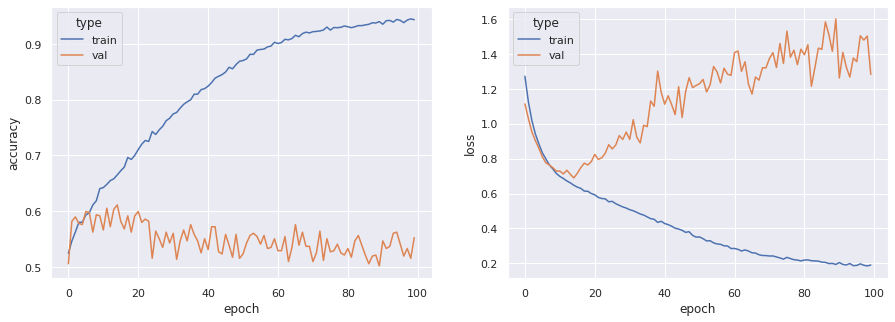

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.lineplot(x='epoch', y='accuracy', data=acc, hue='type', ax=ax[0])
sns.lineplot(x='epoch', y='loss', data=loss, hue='type', ax=ax[1])
plt.show()

In [22]:
acc.loc[acc.epoch == acc.epoch.max()]

,epoch,accuracy,type
99,99,0.943391,train
199,99,0.552734,val


In [23]:
loss.loc[loss.epoch == loss.epoch.max()]

,epoch,loss,type
99,99,0.189992,train
199,99,1.282626,val


### Evaluación de datos de prueba

In [2]:
!python PredictionsTest.py -i testinput -o testoutput/v10

[nltk_data] Downloading package punkt to /home/melesio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/melesio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/melesio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/melesio/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/melesio/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Leyendo archivo de configuracion
Inicia la transformacion de texto
Creando diccionario de documentos unicos
Realizando preprocesamiento
Etapa de pre-procesmiento
Extrayendo vectores de caracteristicas
Etapa de extraccion de caracteristicas
Extraccion de vectores lexicos
Realizando vectorizacion


In [3]:
!python pan22_verif_evaluator.py -i testinput -a testoutput/v10 -o testoutput/v10

-> 1070 problems in ground truth
-> 1070 solutions explicitly proposed
{'auc': 0.475, 'c@1': 0.501, 'f_05_u': 0.542, 'F1': 0.62, 'brier': 0.581, 'overall': 0.544}
